### Import moduels and libraries for use

In [81]:
import nltk
import urllib
import pandas as pd
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from textblob import TextBlob
from nltk.util import ngrams
from collections import Counter
from operator import itemgetter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import os
import re
from sklearn.manifold import TSNE
from collections import defaultdict
from nltk.corpus import stopwords
import gensim
from sklearn.manifold import TSNE
import gensim
import string
from gensim import corpora
import networkx as nx
import matplotlib.pyplot as plt
from plotly.offline import iplot, plot
import plotly.graph_objs as go
import numpy as np
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import pickle

### Get text from Gutenberg

In [2]:
oliver = urllib.request.urlopen('http://www.gutenberg.org/cache/epub/730/pg730.txt').read()
oliver_lines = oliver.decode('utf8')

### Function to search chapters

In [3]:
def find_chapters(book):
    chapters = {}
    i = 0
    b = 0
    for x in range(1, 54):
        i = book.find("CHAPTER ", + b)
        b = book.find("CHAPTER ", i + 1)
        chapters['Chapter {}'.format(x)] = book[i:b]
    return chapters

### Stopwords, cleaning and lemmatizing 

In [4]:
stop = stopwords.words('english') + ['mr',
                                     'mrs',
                                     'miss', 
                                     'say',
                                     'have', 
                                     'might',
                                     'thought',
                                     'would', 
                                     'could', 
                                     'make', 
                                     'much',
                                     'dear',
                                     'must',
                                     'know',
                                     'one',
                                     'good',
                                     'every',
                                     'towards',
                                     'give',
                                     'come',
                                     'go',
                                     'well',
                                     'see',
                                     'think',
                                     'though',
                                     'never',
                                     'always',
                                     'although',
                                     'may',
                                     'soon',
                                     'wish',
                                     'take',
                                     'great',
                                     'nothing',
                                     'something',
                                     'young',
                                     'look',
                                     'even',
                                     'cannot',
                                     'many',
                                     'few',
                                     'even',
                                     'however',
                                     'like',
                                     'lucas'
                                     'ever',
                                     'feel',
                                     'shall',
                                     'hope',
                                     'sure',
                                     'yes',
                                     'no',
                                     'oh',
                                     'two',
                                     'three',
                                     'first',
                                     'second',
                                     'third',
                                     'with',
                                     'without',
                                     'use',
                                     'quite',
                                     'dont',
                                     'oliver',
                                     'fagin',
                                     'nancy',
                                     'bill',
                                     'dodger',
                                     'mrbrownlow',
                                     'mrbumble',
                                     'charley',
                                     'dodger',
                                     'mrsowerberry',
                                     'mrssowerberry',
                                     'mrsmaylie',
                                     'noah',
                                     'charlotte',
                                     'sikes',
                                     'maylie',
                                     'bates',
                                     'toby' ,
                                     'gamfield',
                                     'grimwig',
                                     'barney',
                                     'chitling',
                                     'harry',
                                     'giles',
                                     'monk',
                                     'jew']

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'
    
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    try:
        tag = get_wordnet_pos(nltk.pos_tag([word])[0][1])
        return lemmatizer.lemmatize(word, pos=tag)
    except:
        pass

### Split corpus into sentences, clean and lemmatize

In [5]:
def all_sentences(corpus,
                  include_stop=True):
    vocab = []
    
    text = corpus.replace('Oliver Twist', 'Oliver')\
                 .replace('Bill Sikes', 'Bill')\
                 .replace('Mr. Brownlow', 'MrBrownlow')\
                 .replace('Mr. Bumble', 'MrBumble')\
                 .replace('Charley Bates', 'Charley')\
                 .replace('Artful Dodger', 'Dodger')\
                 .replace('Mr. Sowerberry', 'MrSowerberry')\
                 .replace('Mrs. Sowerberry', 'MrsSowerberry')\
                 .replace('Mrs. Maylie', 'MrsMaylie')\
                 .replace('Jew', 'Fagin')\
                 .replace('Noah Claypole', 'Noah')
    
    sentiment_list = []
    
    for line in sent_tokenize(text):
        
        line= re.sub('[%s]|Chapter' % re.escape(string.punctuation), '', line)
        line = re.sub('[^a-zA-Z\ ]', '', line)
        line = line.lower()
        line = line.split()
        if include_stop:
            line = [lemmatize_word(x) for x in line if lemmatize_word(x) not in stop]
        else:
            line = [lemmatize_word(x) for x in line]
        vocab.append(line)
    return vocab

### Function to get word frequencies

In [6]:
def get_frequecies(corpus):
    dictionary = corpora.Dictionary(corpus)
    # You can check the mapping by caling 'token2id' attribute.
    id_map = dictionary.token2id
    count_map = dictionary.dfs
    word_count = {}
    for word, id_ in id_map.items():
        word_count[word] = count_map[id_]
    sorted_corpus = sorted([(x,y) 
                           for x,y in word_count.items()], 
                           key=lambda x: x[1], reverse=True)
    return sorted_corpus

### Top Keywords in Full Corpus

In [7]:
full_corpus = all_sentences(oliver_lines[6255:-19184])
frequencies = get_frequecies(full_corpus)
frequencies[:10]

[('reply', 500),
 ('upon', 388),
 ('old', 378),
 ('man', 339),
 ('boy', 322),
 ('time', 310),
 ('gentleman', 291),
 ('hand', 283),
 ('cry', 229),
 ('lady', 228)]

### Total Unique Words

In [8]:
len(frequencies)

16217

### Check to see if corpus follows Kip's law

In [9]:
full_corpus2 = all_sentences(oliver_lines[6255:-19184], include_stop=False)
frequencies2 = get_frequecies(full_corpus2)
samples2 = list(dict(frequencies2).keys())
freqs2 = list(dict(frequencies2).values())

df_words = pd.DataFrame()
df_words['frequency'] = freqs2
df_words['word'] = samples2

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = np.log(df_words['frequency']), x = np.log(df_words.index + 1)))

fig.update_layout(go.Layout(
    title='Word Rank vs Word Frequency in Oliver Twist<br>by Charles Dickens<br><sub>Including Stop Words</sub>',
    width=500,
    height=500,
    xaxis=dict(
        title='Log Rank' 
    ),
    yaxis=dict(
        title='Log Frequency', tickfont=dict(size=7)
    )
))
fig.show()

### Top keywords in each chapter

In [64]:
text = find_chapters(oliver_lines[6255:-19184])
for chapter in ['Chapter {}'.format(x) for x in range(1, 54)]:
    corpus = all_sentences(text[chapter])
    print('{}'.format(chapter), get_frequecies(corpus)[:5])

Chapter 1 [('child', 7), ('surgeon', 7), ('nurse', 5), ('hand', 5), ('head', 4)]
Chapter 2 [('mann', 24), ('gentleman', 17), ('beadle', 16), ('boy', 16), ('sir', 11)]
Chapter 3 [('gentleman', 28), ('old', 15), ('boy', 14), ('white', 12), ('waistcoat', 11)]
Chapter 4 [('undertaker', 23), ('boy', 12), ('reply', 11), ('beadle', 10), ('little', 7)]
Chapter 5 [('old', 15), ('sir', 14), ('undertaker', 12), ('reply', 12), ('woman', 12)]
Chapter 6 [('workus', 8), ('reply', 6), ('head', 5), ('bad', 4), ('eye', 4)]
Chapter 7 [('reply', 14), ('sir', 11), ('boy', 10), ('upon', 6), ('time', 6)]
Chapter 8 [('gentleman', 14), ('boy', 13), ('old', 9), ('little', 9), ('london', 8)]
Chapter 9 [('old', 16), ('time', 11), ('reply', 11), ('sir', 11), ('boy', 10)]
Chapter 10 [('gentleman', 16), ('stop', 15), ('old', 14), ('thief', 11), ('boy', 10)]
Chapter 11 [('fang', 33), ('old', 20), ('man', 16), ('gentleman', 16), ('reply', 14)]
Chapter 12 [('old', 32), ('lady', 25), ('gentleman', 13), ('sir', 13), ('li

### Get edgelist from text characters and chapters

In [65]:
edge_list = []
for chapter in ['Chapter {}'.format(x) for x in range(1, 54)]:
    text[chapter] = text[chapter].replace('Oliver Twist', 'Oliver')\
                                 .replace('Bill Sikes', 'Bill')\
                                 .replace('Mr. Brownlow', 'MrBrownlow')\
                                 .replace( 'Mr. Bumble', 'MrBumble')\
                                 .replace('Charley Bates', 'Charley')\
                                 .replace('Artful Dodger', 'Dodger')\
                                 .replace('Mr. Sowerberry', 'MrSowerberry')\
                                 .replace('Mrs. Sowerberry', 'MrsSowerberry')\
                                 .replace('Mrs. Maylie', 'MrsMaylie')\
                                 .replace('Jew', 'Fagin')\
                                 .replace('Noah Claypole', 'Noah')

    for name in ['Oliver',
                 'Fagin',
                 'Nancy',
                 'Bill',
                 'Dodger',
                 'MrBrownlow',
                 'MrBumble',
                 'Charley',
                 'Dodger',
                 'MrSowerberry',
                 'MrsSowerberry',
                 'MrsMaylie',
                 'Noah',
                 'Charlotte',
                 'Monks']:
        #print(chapter, name, len(re.findall(name, text[chapter])))
        edge_list.append((chapter, name, len(re.findall(name, text[chapter]))))

data_df = pd.DataFrame(edge_list)
data_df.columns = ['Chapter', 'Character', 'Weight']
data_df = data_df[data_df['Weight']>0]

### Build graph

In [13]:
B = nx.Graph()

B.add_nodes_from(data_df['Chapter'],
                 bipartite=0)
B.add_nodes_from(data_df['Character'],
                 bipartite=1)

B.add_weighted_edges_from(
    [(row['Chapter'], 
      row['Character'],
      row['Weight']) for idx, row in data_df.iterrows()])

### Get character projection

In [14]:
character_filter = {n for n, d in B.nodes(data=True) if d['bipartite']==1}

# project bipartite graph onto character nodes keeping number of co-occurences, weighted degree
B_character = nx.bipartite.weighted_projected_graph(B, character_filter)

### Network graph

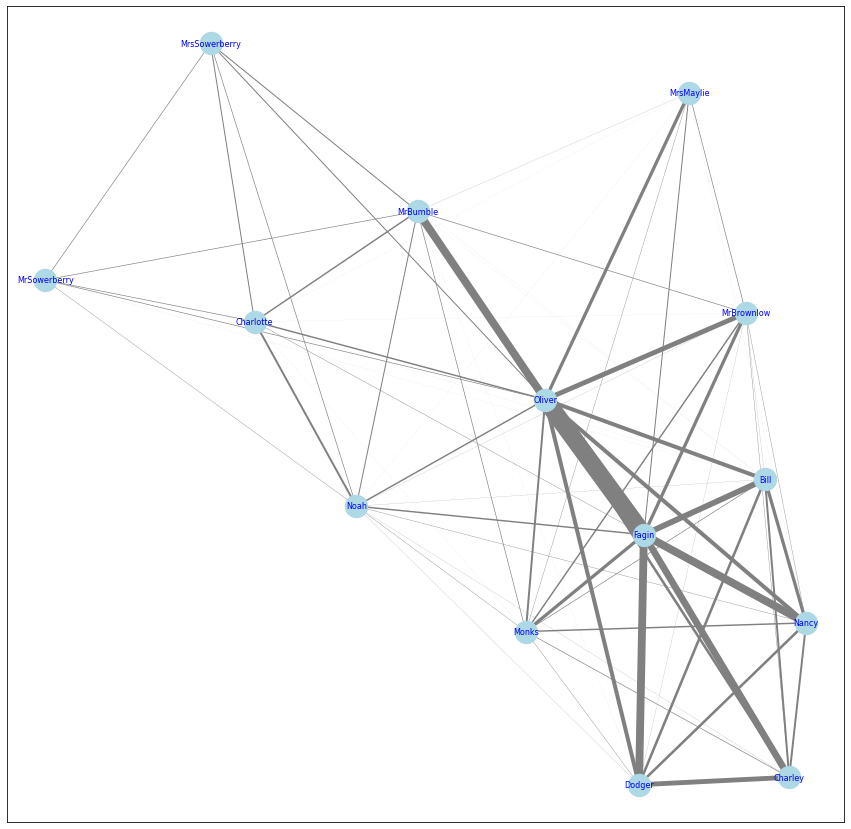

In [15]:
plt.figure(figsize=(15,15));
pos = nx.spring_layout(B_character, iterations = 50);
edges = B_character.edges()
weights = [(B_character[u][v]['weight']/5)**2 for u,v in edges]
nx.draw_networkx_nodes(B_character, pos, node_color='lightblue', node_size=500);
nx.draw_networkx_edges(B_character, pos,  edge_color='gray', width=weights);
nx.draw_networkx_labels(B_character, pos, font_size=8, font_color ='blue');

### Character degree centrality

In [16]:
char_deg_cent = {k:v for k,v in dict(nx.degree_centrality(B)).items()}
print('Character Degree Centrality ')
print('-----------------------------------------------')
for character, cdegree in sorted([(x,y) 
              for x,y in char_deg_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(character), 'Degree Centrality:',round(cdegree,3))

Character Degree Centrality 
-----------------------------------------------
Oliver - Degree Centrality: 0.621
Fagin - Degree Centrality: 0.47
MrBumble - Degree Centrality: 0.227
Nancy - Degree Centrality: 0.227
Bill - Degree Centrality: 0.212


### Character betweenness centrality

In [17]:
b_bet_cent = {k:v for k,v in dict(nx.betweenness_centrality(B_character)).items()}
print('Character Betweenness Centrality ')
print('-----------------------------------------------')
for character, cdegree in sorted([(x,y) 
              for x,y in b_bet_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(character), 'Betweenness Centrality:',round(cdegree,3))

Character Betweenness Centrality 
-----------------------------------------------
Noah - Betweenness Centrality: 0.055
Oliver - Betweenness Centrality: 0.055
Bill - Betweenness Centrality: 0.043
MrBumble - Betweenness Centrality: 0.033
Charlotte - Betweenness Centrality: 0.031


### Create function for NMF and LDA

In [18]:
def NMF_LDA(text):
    maxdf = .5
    mindf = 5
    no_top_words = 10
    no_topics = 5

    tfidf_vectorizer1 = TfidfVectorizer(ngram_range=(1, 1),
                                        max_df=maxdf, 
                                        min_df=mindf, 
                                        stop_words=stop)
    tfidf1 = tfidf_vectorizer1.fit_transform(text)
    tfidf_feature_names1 = tfidf_vectorizer1.get_feature_names()

    ct_vectorizer1 = CountVectorizer(ngram_range=(1, 1),
        max_df=maxdf, min_df=mindf, stop_words=stop)
    ct1 = ct_vectorizer1.fit_transform(text)
    tf_feature_names1 = ct_vectorizer1.get_feature_names()

    # Run NMF
    nmf1 = NMF(n_components=no_topics,
               max_iter=300)
    nmf1.fit_transform(tfidf1)

    # Run LDA
    lda1 = LatentDirichletAllocation(n_components=no_topics, 
                                     max_iter=10,
                                     learning_method='online', 
                                     learning_offset=50.,
                                     random_state=0).fit(ct1)
    def display_topics(model, feature_names, no_top_words, model_used):
        topic_dict={}
        for topic_idx, topic in enumerate(model.components_):
            topic_dict["Topic:{}".format(topic_idx+1)]=" ".join(set([feature_names[i].title()
            for i in topic.argsort()[:-no_top_words - 1:-1]]))
        return pd.DataFrame.from_dict(topic_dict,
                                      orient='index')\
                                      .reset_index()\
                                      .rename(columns={'index':'Topic',
                                                       0:'Top Words'})
    
    return display_topics(nmf1, 
                          tfidf_feature_names1, 
                          no_top_words, 
                          "NMF"),\
           display_topics(lda1, 
                          tf_feature_names1, 
                          no_top_words, "LDA")

### Turn lists back into sentences

In [19]:
topic_corpus =  [' '.join(x) for x in full_corpus]

### Get NMF and LDA topics

In [20]:
NMF_LDA_Tuple = NMF_LDA(topic_corpus)

In [21]:
NMF_LDA_Tuple[0]['Top Words'].tolist()

['Beadle Maam Girl Woman Reply Man Indeed Rise Course Sir',
 'Eh Thats Time Anything Tell Mean Ah Ha Em Get',
 'Ask Girl Cry Man Gentleman Lady Old Hand Rise Upon',
 'Name Return Thats Poor Whats Mean Little Boy Get Sir',
 'Beadle Fang Losberne Bumble Poor Man Gentleman Inquire Blather Matron']

In [22]:
NMF_LDA_Tuple[1]['Top Words'].tolist()

['Maam Reply Speak Let Begin Air Ha Hour Get Sir',
 'Turn Face Ask Back Away Old Boy Round Hand Upon',
 'Way Put Girl Cry Light Tell Street Rise Rejoin Ill',
 'Long Ever Hear Doctor Mind Thats Man Time Heart Upon',
 'Woman Gentleman Eye Head Word Lady Inquire Old Enough Get']

### Plot W2V with TNSE

In [23]:
def W2V(nlp_list):
    
    model = gensim.models.Word2Vec(nlp_list,
                                   size=100,
                                   window=10,
                                   min_count=3,
                                   workers=2)


    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=30, 
                      n_components=2, 
                      init='pca', 
                      n_iter=250, 
                      angle=.8)
    
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    df = pd.DataFrame([x, y, labels]).T
    df.columns = ['x','y','label']
        
    return df

In [24]:
full_corpus = all_sentences(oliver_lines[6255:-19184], include_stop=False)
w2v_df = W2V(full_corpus)

/Users/jitsen/anaconda/envs/ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [25]:
character_list = ['oliver',
                  'fagin',
                  'nancy',
                  'bill',
                  'dodger',
                  'mrbrownlow',
                  'mrbumble',
                  'charley',
                  'dodger',
                  'mrsowerberry',
                  'mrssowerberry',
                  'mrsmaylie',
                  'noah',
                  'charlotte',
                  'monks']

character_list = [x.lower() for x in character_list]

df = w2v_df[w2v_df['label'].isin(character_list)]


text_pos = [x for x in np.random.choice(['top left', 
                                         'bottom left',
                                         'top right',
                                         'bottom right'], 
                                          len(df),
                                          p=[.2,.3,.3,.2])]


trace = go.Scatter(x=df['x'],
                   y=df['y'],
                   mode='markers+text', 
                   textposition=text_pos,
                   text=df['label'],
                   textfont=dict(size=8),
                   hoverinfo='text')



fig = go.Figure([trace])

fig.update_layout(go.Layout(
    title='Word2Vec Name Vector Similarity',
    ),
    hovermode='closest',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=800,
    height=800
)

In [70]:
def sentiment_calculator(text):
    
    
    sentiment_list = []
    subjectivity_list = []
    
    for line in sent_tokenize(text):
        sentiment_tuple = TextBlob(line).sentiment
        sentiment_list.append(sentiment_tuple[0])
        subjectivity_list.append(sentiment_tuple[1])
    
    return np.mean(sentiment_list),np.mean(subjectivity_list)
    

### Sentiment and Subjectivity

In [78]:
text = find_chapters(oliver_lines[6255:-19184])
sentiment_list = []
subjectivity_list = []
for chapter in ['Chapter {}'.format(x) for x in range(1, 54)]:
    text[chapter] = text[chapter].replace('Oliver Twist', 'Oliver')\
                             .replace('Bill Sikes', 'Bill')\
                             .replace('Mr. Brownlow', 'MrBrownlow')\
                             .replace( 'Mr. Bumble', 'MrBumble')\
                             .replace('Charley Bates', 'Charley')\
                             .replace('Artful Dodger', 'Dodger')\
                             .replace('Mr. Sowerberry', 'MrSowerberry')\
                             .replace('Mrs. Sowerberry', 'MrsSowerberry')\
                             .replace('Mrs. Maylie', 'MrsMaylie')\
                             .replace('Jew', 'Fagin')\
                             .replace('Noah Claypole', 'Noah')
    
    sentiment_tuple = sentiment_calculator(text[chapter])
    sentiment_list.append(sentiment_tuple[0])
    subjectivity_list.append(sentiment_tuple[1])

In [83]:
np.mean(sentiment_list), np.mean(subjectivity_list)

(0.051816760030566664, 0.29639581221225514)

In [91]:
with open('oliver_sentiment_subjectivity.pkl','wb') as f:
    pickle.dump((sentiment_list, subjectivity_list), f)

In [92]:
with open('pride_sentiment_subjectivity.pkl','rb') as f:
     pride_sentiment_subjectivity = pickle.load(f)

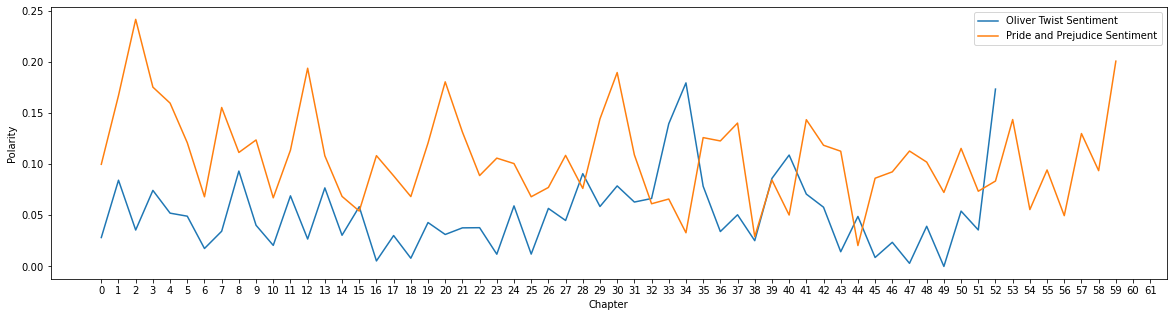

In [96]:
plt.figure(figsize=(20,5))
plt.plot(sentiment_list,label='Oliver Twist Sentiment');
plt.plot(pride_sentiment_subjectivity[0], label='Pride and Prejudice Sentiment');
plt.ylabel('Polarity');
plt.xlabel('Chapter');
plt.xticks([x for x in range(62)])
plt.legend();